# Multi-Agent System Designer

In [11]:
with open("./system-design-assistant-prompt.md") as f:
    writer_prompt = f.read()

with open("./requirement_analyzer_prompt.txt") as f:
    analyzer_prompt = f.read()

with open("./diagram_drawer_prompt.txt") as f:
    drawer_prompt = f.read()

In [12]:
import operator
from typing import Annotated, Sequence, TypedDict

from langchain_openai import ChatOpenAI
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)

# `add_messages`` essentially does this
# (with more robust handling)
# def add_messages(left: list, right: list):
#     return left + right


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

In [13]:
from typing import Literal
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import END, StateGraph


def create_agent(
    llm,
    prompt: str,
    tools,
    options = ["WRITE DOC", "ANALYZE REQUIREMENT", "FINAL ANSWER"],
):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                prompt
                + " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    # prompt = prompt.partial(options=", ".join([opt for opt in options]))
    return prompt | llm.bind_tools(tools)

In [14]:
import functools
import orjson

from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities import GoogleSearchAPIWrapper
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import END, MessageGraph
from langgraph.prebuilt.tool_node import ToolNode
from langchain_core.tools import Tool
from langchain_core.messages import AIMessage

# Define the function that determines whether to continue or not
# Either agent can decide to end
from typing import Literal

from langchain_core.pydantic_v1 import BaseModel


class AskHuman(BaseModel):
    """Ask the human a question"""
    name: str = "ask_human"
    question: str


# def router(state) -> Literal["call_tool", "__end__", "continue"]:
#     # This is the router
#     messages = state["messages"]
#     last_message = messages[-1]
#     if last_message.tool_calls:
#         # The previous agent is invoking a tool
#         return "call_tool"

#     if "WRITE DOC" in last_message.content:
#         return "document_writer"

#     if "ANALYZE REQUIREMENT" in last_message.content:
#         return "document_writer"

#     if "FINAL ANSWER" in last_message.content:
#         # Any agent decided the work is done
#         return "__end__"
#     return "continue"


def router(state) -> Literal["call_tool", "end", "continue"]:
    messages = state["messages"]
    last_message = messages[-1]

    # if hasattr(last_message, 'tool_calls') and not last_message.tool_calls:
    #     return "end"

    if isinstance(last_message, AIMessage) and last_message.tool_calls:
        return "call_tool"

    if (
        last_message.content.strip().upper() == "FINALIZE"
        or last_message.content.strip().upper() == "WRITE_DOC"
    ):
        return "document_writer"

    if last_message.content.strip().upper() == "FINAL ANSWER":
        return "__end__"

    return "continue"


def agent_node(state, agent, name):
    result = agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
        
    return {
        "messages": state['messages'] + [result],
        "sender": name,
    }


def user_input_node(state):
    user_input = input(
        "Please provide more details or type 'FINALIZE' to proceed: "
    )
    # state["messages"].append()
    return {
        "messages": state["messages"] + [HumanMessage(content=user_input)],
        "sender": "human",
    }


tavily_tool = TavilySearchResults(max_results=5)
# Define a new graph
workflow = StateGraph(AgentState)


tools = [tavily_tool]
llm = ChatOpenAI(model="gpt-4o")
requirement_analyzer = create_agent(llm, analyzer_prompt, tools)
analyzer_node = functools.partial(
    agent_node, agent=requirement_analyzer, name="Requirement_Analyzer"
)
doc_writer = create_agent(llm, writer_prompt, tools)
writer_node = functools.partial(
    agent_node, agent=doc_writer, name="Doc_Writer"
)
tool_node = ToolNode(tools)
workflow.add_node("requirement_analyzer", analyzer_node)
workflow.add_node("document_writer", writer_node)
workflow.add_node("call_tool", tool_node)
workflow.add_node("user_input", user_input_node)

# Conditional agent -> action OR agent -> END
# Add conditional edges to the workflow
workflow.add_conditional_edges(
    "requirement_analyzer",
    router,
    {
        "ask_human": "user_input",
        "continue": "user_input",
        "call_tool": "call_tool",
        "document_writer": "document_writer",
        "FINALIZE": "document_writer",
    },
)
workflow.add_conditional_edges(
    "document_writer",
    router,
    {
        "continue": "user_input",
        "call_tool": "call_tool",
        "revise": "document_writer",
        "requirement_analyzer": "requirement_analyzer",
        "__end__": END,
    },
)
workflow.add_conditional_edges(
    "user_input",
    router,
    {
        "requirement_analyzer": "requirement_analyzer",
        "document_writer": "document_writer",
        "continue": "requirement_analyzer",
    },
)
workflow.add_conditional_edges(
    "call_tool",
    lambda x: x["sender"],
    {
        "requirement_analyzer": "requirement_analyzer",
        "document_writer": "document_writer",
    },
)
workflow.set_entry_point("user_input")
memory = SqliteSaver.from_conn_string(":memory:")  # Here we only save in-memory

# Setting the interrupt means that any time an action is called, the machine will stop
app = workflow.compile(checkpointer=memory, interrupt_before=["call_tool"])

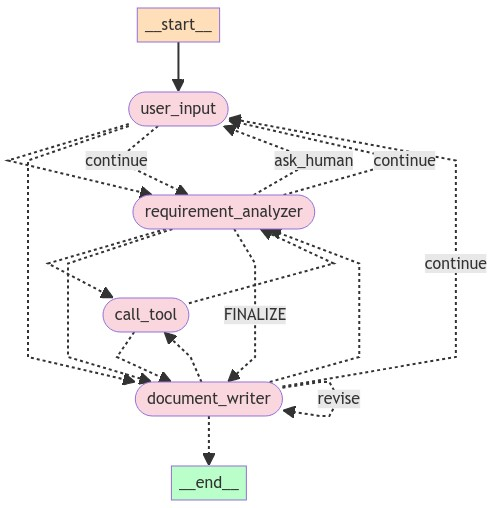

In [15]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [17]:
import uuid


config = {
    "recursion_limit": 150,
    "configurable": {
        "thread_id": str(uuid.uuid4()),  # Replace with actual thread_id value
        "thread_ts": str(uuid.uuid4()),  # Replace with actual thread_ts value
    },
}

# while True:
#     user_input = input("User (type 'FINALIZE REQUIREMENTS' to proceed, 'q/Q to quit): ")
#     if user_input in {"q", "Q"}:
#         print("AI: Byebye")
#         break

state = {
    "messages": [],
    "system_message": "Your job is to assist users writing system design documents.",
}


for s in app.stream(state, config):
    if "end" not in s:
        role = list(s.keys())[0]
        messages = s[role].get("messages")

        print(f"{role}:\n{messages[-1].content}\n")

        if messages:
            last_message = messages[-1]
            if "q" == last_message.content or "Q" == last_message.content:
                break
    # else:
    #     print("！！！")
    #     print("Done!")
    #     break

    if "__end__" in s:
        print("Done!")
        break

user_input:
Please help me write a system design document for a stock ranking system. Main Objectives: 1. Help investors select stocks based on the ranked factor values  Requirements: 1. Users receive a sorted table of stocks based on the factor value 2. Users can select the date of the factor data  Constraints: 1. Data must be point-in-time 2. The stock ranking system receives data from another data ingestion system  Specific Requirement: 1. Data must be point-in-time 2. Output should be sorted by factor value. If there are multiple factors, the result must be based on the weighted sum of factor values.  If you are not sure about the details of each section, feel free to ask.

requirement_analyzer:
Hello! I am here to help you analyze and extract precise requirements for your stock ranking system design document. Let's break down your requirements step-by-step to ensure we capture all necessary details.

### 1. System Overview
**Question**: Could you provide more details about the ove

RateLimitError: Error code: 429 - {'error': {'message': 'Request too large for gpt-4o in organization org-opKAiRU0sQwtNZvJm5E0t6t3 on tokens per min (TPM): Limit 30000, Requested 50798. The input or output tokens must be reduced in order to run successfully. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}

In [ ]:
import uuid


config = {
    "recursion_limit": 150,
    "configurable": {
        "thread_id": str(uuid.uuid4()),  # Replace with actual thread_id value
        "thread_ts": str(uuid.uuid4()),  # Replace with actual thread_ts value
    },
}

# while True:
#     user_input = input("User (type 'FINALIZE REQUIREMENTS' to proceed, 'q/Q to quit): ")
#     if user_input in {"q", "Q"}:
#         print("AI: Byebye")
#         break

state = {
    "messages": [],
    "system_message": "Your job is to assist users writing system design documents.",
}

while True:
    output = None
    for s in app.stream(state, config):
        if "__end__" not in s:
            print(s)
            role = list(s.keys())[0]
            last_message = s[role].get("messages")
            
            if last_message:
                state["messages"].append(last_message[-1])
                if "requirement_analyzer" in s or "user_input" in s:
                    break
                elif "document_writer" in s:
                    print("Document writer is proceeding with the given requirements.")
                    break
        else:
            print(s)
            break

    if "__end__" in s:
        print("Done!")
        break

In [ ]:

config = {"configurable": {"thread_id": str(uuid.uuid4())}}
while True:
    user = input("User (q/Q to quit): ")
    if user in {"q", "Q"}:
        print("AI: Byebye")
        break
    output = None
    for output in app.stream(
        {
            "messages": [HumanMessage(content=user)],
        },
        config=config,
        stream_mode="updates",
    ):
        last_message = next(iter(output.values()))
        last_message.pretty_print()

    if output and "prompt" in output:
        print("Done!")